# JWST Fetch Crowded Field Spectral Products

## Introduction

This tutorial will demonstrate how to use [astroquery.mast](https://astroquery.readthedocs.io/en/latest/mast/mast.html) to retrieve JWST data products. Our goal is to retrieve the set of spectral data products needed to run the JWST processing pipeline to perform our own extractions within crowded fields, e.g., within a stellar cluster, the Galactic center, or a deep image of a galaxy cluster.  This notebook walks through the process as follows:

* First we will demonstrate how to use `astroquery.mast` to perform the three basics of data search and retrieval. We will use images from the Early Relase Observation (ERO) of NGC 3132 (the Southern Ring Nebula) for just this first part.  The basic steps to download data from MAST are:
    1. Conduct a search for observations.
    2. Retrieve the set of products for those observations.
    3. Download the products you want.
* Next we will walk through these steps for a wide-field slitless spectroscopy program, and explain some of the challenges of the steps above when there can be thousands of products associated with the observations. We will show how you can filter these products to only get the ones you need, and demonstrate the batch download technique we recommend when requesting large amounts of data, to make your retrieval process as smooth as possible. 

## Table of Contents
- [Imports](#Imports)<br>
- [The Basics Of Searching and Downloading Data Through astroquery.mast](#The-Basics-Of-Searching-and-Downloading-Data-Through-astroquery.mast)<br>
    - [Step 1: Searching For Observations](#Step-1:-Searching-For-Observations)<br>
        - [Search By Object Coordinates](#Search-By-Object-Coordinates)<br>
        - [Search By Resolvable Object Name](#Search-By-Resolvable-Object-Name)<br>
        - [Search By Observational Metadata](#Search-By-Observational-Metadata)<br>
    - [Step 2: Retrieving Data Products](#Step-2:-Retrieving-Data-Products)
    - [Step 3: Downloading Data Products](#Step-3:-Downloading-Data-Products)
- [Downloading Calibrated Data For Multi-Object Spectral Programs](#Downloading-Calibrated-Data-For-Multi-Object-Spectral-Programs)

## Imports
* We use the astropy `Units` module to define physical units.
* We use the `SkyCoord` class from the `astropy.coordinates` module to define coordinates.
* We use `fits` module from astropy.io to read data contained in FITS files.
* We import a couple options from `astropy.visualization` for applying scaling and stretches.
* The `Observations` class from the `astroquery.mast` module allows you to query by coordinates, resolvable target names, or observational metadata like program IDs, filters, or exposure times.

* We use `matplotlib.pyplot` for plotting and image display.

In [1]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.visualization import ZScaleInterval, SquaredStretch, ImageNormalize
from astroquery.mast import Observations
import matplotlib.pyplot as plt

## The Basics Of Searching and Downloading Data Through astroquery.mast

We'll use the ERO observations of the Southern Ring Nebula to show you how to search for observations.  You can use the `Observations` module of `astroquery.mast` in a variety of ways, including [by position](https://astroquery.readthedocs.io/en/latest/mast/mast.html#positional-queries) or by [observational metadata](https://astroquery.readthedocs.io/en/latest/mast/mast.html#observation-criteria-queries).

### Step 1: Searching For Observations

The first step in downloading JWST data products through `astroquery.mast` is to search for observations of interest.  There are several ways to find observations of interest, so in this section, we will demonstrate how to do: 

* a cone search by providing coordinates, 
* a cone search by providing a resolvable target name, 
* and a search based on observational metadata

#### Search By Object Coordinates.

First, let's search for observations by sky coordinates of the object directly.

In [2]:
# Define the coordinates of the object.
obj_coords = SkyCoord("10:07:01", "-40:26:14", unit=(u.hourangle, u.deg))

# Conduct a cone search centered on these coordinates.  The default search radius is 0.2 degrees.  Let's use a much
# smaller search radius of one arcminute.
obs_table = Observations.query_region(obj_coords, radius="1.0 arcmin")

We get back an Astropy table containing observations whose footprints fall within our search radius.  But notice that this includes data from lots of missions, e.g., TESS, WUPPE, etc.  This is because the simple cone search operates across all the missions in our cross-mission database.  We'll show later how to do a search and only get back JWST mission data. A description of the columns returned from an observation search are [documented here](https://mast.stsci.edu/api/v0/_c_a_o_mfields.html).

In [4]:
# The show_in_notebook() function allows us to explore an Astropy table with pagination and search capability.
# Try searching for the JWST entries.

# One of the return columns is called the 's_region', which contains the polygonal representation of the footprint
# on the sky.  This is a very long string, and makes viewing the rest of the table difficult in a notebook. So
# we will get a list of all the coumns except this one for display purposes.
display_columns = [x for x in obs_table.columns if x != "s_region"]

# Show the contents of the table.
obs_table[display_columns].show_in_notebook(display_length=5)

idx,intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,distance
0,science,WUPPE,--,ASTRO-2 WUPPE,--,--,UV,NGC3132,--,ngc3132_410911_2,151.7577852819,-40.43465143,spectrum,--,1,49791.03055556,49791.0512963,1792.0,170400000000.0,277400000000.00006,--,nan,--,--,--,http://archive.stsci.edu/pub/browse/previews/astro/wuppe/gif/ngc3132_410911_2_hwa.gif,http://archive.stsci.edu/pub/vospectra/wuppe2/ngc3132_410911_2_hw_vo.fits,PUBLIC,--,5885.0,389320,8.362941846686795
1,science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0009-2-2,157.48628713094715,-43.22571855614874,image,"Ricker, George",3,58542.73242914352,58567.9618940162,1425.599414,600.0,1000.0,--,58609.3333334,N/A,--,9,--,--,PUBLIC,False,nan,62894034,0.0
2,science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0036-2-1,149.12522577936127,-39.2835424391434,image,"Ricker, George",3,59280.406030439815,59305.4891190625,475.199787,600.0,1000.0,--,59327.0,N/A,--,36,--,--,PUBLIC,False,nan,60827609,0.0
3,science,SPITZER_SHA,SSC Pipeline,IRAC,--,IRAC3,Infrared,NGC 3132,--,000000436500,151.755292,-40.436056,image,"Fazio, Giovanni",3,52993.89252381,52993.89882872,26.8,5020.0,6410.0,Studying Stellar Ejecta on the Large Scale using SIRTF-IRAC,53545.2916667,STELLAREJECTA_68,--,4416768,--,https://irsa.ipac.caltech.edu/data/SPITZER/SHA/archive/proc/IRAC003600/r4416768/ch3/pbcd/SPITZER_I3_4416768_0000_7_E8349184_maic.fits,PUBLIC,False,nan,1748827,0.0
4,science,SPITZER_SHA,SSC Pipeline,IRAC,--,IRAC4,Infrared,NGC 3132,--,000000436500,151.755292,-40.436056,image,"Fazio, Giovanni",3,52993.89252381,52993.89882872,26.8,6430.0,9280.0,Studying Stellar Ejecta on the Large Scale using SIRTF-IRAC,53545.2916667,STELLAREJECTA_68,--,4416768,--,https://irsa.ipac.caltech.edu/data/SPITZER/SHA/archive/proc/IRAC003600/r4416768/ch4/pbcd/SPITZER_I4_4416768_0000_7_E8348786_maic.fits,PUBLIC,False,nan,1748827,0.0
5,science,SPITZER_SHA,SSC Pipeline,IRAC,--,IRAC1,Infrared,NGC 3132,--,000000436500,151.755292,-40.436056,image,"Fazio, Giovanni",3,52993.89252381,52993.89882872,26.8,3170.0,3950.0000000000005,Studying Stellar Ejecta on the Large Scale using SIRTF-IRAC,53545.2916667,STELLAREJECTA_68,--,4416768,--,https://irsa.ipac.caltech.edu/data/SPITZER/SHA/archive/proc/IRAC003600/r4416768/ch1/pbcd/SPITZER_I1_4416768_0000_7_A42446629_maics.fits,PUBLIC,False,nan,1748827,0.0
6,science,SPITZER_SHA,SSC Pipeline,IRAC,--,IRAC2,Infrared,NGC 3132,--,000000436500,151.755292,-40.436056,image,"Fazio, Giovanni",3,52993.89252381,52993.89882872,26.8,3990.0,5010.0,Studying Stellar Ejecta on the Large Scale using SIRTF-IRAC,53545.2916667,STELLAREJECTA_68,--,4416768,--,https://irsa.ipac.caltech.edu/data/SPITZER/SHA/archive/proc/IRAC003600/r4416768/ch2/pbcd/SPITZER_I2_4416768_0000_7_E8349192_maic.fits,PUBLIC,False,nan,1748827,0.0
7,science,SPITZER_SHA,SSC Pipeline,IRS,--,IRS-LH,Infrared,NGC3132,--,0000010D4700,151.75733300000002,-40.436417,image,"Houck, James R.",3,53914.94061384,53914.94115995,47.183904075063765,18700.0,37200.0,Revealing the nature of Bulge Planetary Nebulae,54308.84664344,JBS2.BULGE_30550,--,17647360,--,https://irsa.ipac.caltech.edu/data/SPITZER/SHA/archive/proc/IRSX006800/r17647360/ch3/pbcd/SPITZER_S3_17647360_0006_7_E7480772_coa2d.fits,PUBLIC,False,nan,1697393,0.0
8,science,SPITZER_SHA,SSC Pipeline,IRS,--,IRS-SL,Infrared,NGC 3132 center,--,000001A17900,151.75741700000003,-40.436083,image,"Sellgren, Kris",3,54846.13118598,54846.13189142,60.95001641660929,5200.0,14500.0,Planetary Nebulae As A Laboratory For Molecular Hydrogen in the Early Universe,54894.83368052,PNH2_50179,--,27359488,--,https://irsa.ipac.caltech.edu/data/SPITZER/SHA/archive/proc/IRSX011800/r27359488/ch0/pbcd/SPITZER_S0_27359488_0023_3_E7859719_coa2d.fits,PU

#### Search By Resolvable Object Name.

Instead of specifying the coordinates, you can provide the name of an object as long as it is resolvable by Simbad, NED, or a KIC, EPIC, or TIC catalog name.  This still does a cone search on the sky, by using the resolver service to translate your provided string into a coordinate on the sky.  It does NOT do a string match for the object name in the MAST database!

In [23]:
# Conduct a cone search by passing a resolvable target name.
obs_table = Observations.query_region("NGC 3132", radius="1.0 arcmin")
len(obs_table)

251

In [4]:
# Show the contents of the table.
display_columns = [x for x in obs_table.columns if x != "s_region"]
obs_table[display_columns].show_in_notebook(display_length=5)

idx,intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,distance
0,science,WUPPE,--,ASTRO-2 WUPPE,--,--,UV,NGC3132,--,ngc3132_410911_2,151.7577852819,-40.43465143,spectrum,--,1,49791.03055556,49791.0512963,1792.0,170400000000.0,277400000000.00006,--,nan,--,--,--,http://archive.stsci.edu/pub/browse/previews/astro/wuppe/gif/ngc3132_410911_2_hwa.gif,http://archive.stsci.edu/pub/vospectra/wuppe2/ngc3132_410911_2_hw_vo.fits,PUBLIC,--,5885.0,389320,8.362941846686795
1,science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0009-2-2,157.48628713094715,-43.22571855614874,image,"Ricker, George",3,58542.73242914352,58567.9618940162,1425.599414,600.0,1000.0,--,58609.3333334,N/A,--,9,--,--,PUBLIC,False,nan,62894034,0.0
2,science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0036-2-1,149.12522577936127,-39.2835424391434,image,"Ricker, George",3,59280.406030439815,59305.4891190625,475.199787,600.0,1000.0,--,59327.0,N/A,--,36,--,--,PUBLIC,False,nan,60827609,0.0
3,science,SPITZER_SHA,SSC Pipeline,IRAC,--,IRAC3,Infrared,NGC 3132,--,000000436500,151.755292,-40.436056,image,"Fazio, Giovanni",3,52993.89252381,52993.89882872,26.8,5020.0,6410.0,Studying Stellar Ejecta on the Large Scale using SIRTF-IRAC,53545.2916667,STELLAREJECTA_68,--,4416768,--,https://irsa.ipac.caltech.edu/data/SPITZER/SHA/archive/proc/IRAC003600/r4416768/ch3/pbcd/SPITZER_I3_4416768_0000_7_E8349184_maic.fits,PUBLIC,False,nan,1748827,0.0
4,science,SPITZER_SHA,SSC Pipeline,IRAC,--,IRAC4,Infrared,NGC 3132,--,000000436500,151.755292,-40.436056,image,"Fazio, Giovanni",3,52993.89252381,52993.89882872,26.8,6430.0,9280.0,Studying Stellar Ejecta on the Large Scale using SIRTF-IRAC,53545.2916667,STELLAREJECTA_68,--,4416768,--,https://irsa.ipac.caltech.edu/data/SPITZER/SHA/archive/proc/IRAC003600/r4416768/ch4/pbcd/SPITZER_I4_4416768_0000_7_E8348786_maic.fits,PUBLIC,False,nan,1748827,0.0
5,science,SPITZER_SHA,SSC Pipeline,IRAC,--,IRAC1,Infrared,NGC 3132,--,000000436500,151.755292,-40.436056,image,"Fazio, Giovanni",3,52993.89252381,52993.89882872,26.8,3170.0,3950.0000000000005,Studying Stellar Ejecta on the Large Scale using SIRTF-IRAC,53545.2916667,STELLAREJECTA_68,--,4416768,--,https://irsa.ipac.caltech.edu/data/SPITZER/SHA/archive/proc/IRAC003600/r4416768/ch1/pbcd/SPITZER_I1_4416768_0000_7_A42446629_maics.fits,PUBLIC,False,nan,1748827,0.0
6,science,SPITZER_SHA,SSC Pipeline,IRAC,--,IRAC2,Infrared,NGC 3132,--,000000436500,151.755292,-40.436056,image,"Fazio, Giovanni",3,52993.89252381,52993.89882872,26.8,3990.0,5010.0,Studying Stellar Ejecta on the Large Scale using SIRTF-IRAC,53545.2916667,STELLAREJECTA_68,--,4416768,--,https://irsa.ipac.caltech.edu/data/SPITZER/SHA/archive/proc/IRAC003600/r4416768/ch2/pbcd/SPITZER_I2_4416768_0000_7_E8349192_maic.fits,PUBLIC,False,nan,1748827,0.0
7,science,SPITZER_SHA,SSC Pipeline,IRS,--,IRS-LH,Infrared,NGC3132,--,0000010D4700,151.75733300000002,-40.436417,image,"Houck, James R.",3,53914.94061384,53914.94115995,47.183904075063765,18700.0,37200.0,Revealing the nature of Bulge Planetary Nebulae,54308.84664344,JBS2.BULGE_30550,--,17647360,--,https://irsa.ipac.caltech.edu/data/SPITZER/SHA/archive/proc/IRSX006800/r17647360/ch3/pbcd/SPITZER_S3_17647360_0006_7_E7480772_coa2d.fits,PUBLIC,False,nan,1697393,0.0
8,science,SPITZER_SHA,SSC Pipeline,IRS,--,IRS-SL,Infrared,NGC 3132 center,--,000001A17900,151.75741700000003,-40.436083,image,"Sellgren, Kris",3,54846.13118598,54846.13189142,60.95001641660929,5200.0,14500.0,Planetary Nebulae As A Laboratory For Molecular Hydrogen in the Early Universe,54894.83368052,PNH2_50179,--,27359488,--,https://irsa.ipac.caltech.edu/data/SPITZER/SHA/archive/proc/IRSX011800/r27359488/ch0/pbcd/SPITZER_S0_27359488_0023_3_E7859719_coa2d.fits,PU

#### Search By Observational Metadata.

You can also perform a search by observational metadata like program ID or instruments and filters.  We used the `query_region` function above to do cone searches.  For metadata queries, we'll use the `query_criteria` function.

First, let's see what metadata is at our disposal to query with. You can view the list of observations metadata on this webpage, or you can do a Python command to see the list of metadata like so: 

In [7]:
Observations.get_metadata('observations').show_in_notebook()

idx,Column Name,Column Label,Data Type,Units,Description,Examples/Valid Values
0,intentType,Observation Type,string,,Whether observation is for science or calibration.,"Valid values: science, calibration"
1,obs_collection,Mission,string,,Collection,"E.g. SWIFT, PS1, HST, IUE"
2,provenance_name,Provenance Name,string,,"Provenance name, or source of data","E.g. TASOC, CALSTIS, PS1"
3,instrument_name,Instrument,string,,Instrument Name,"E.g. WFPC2/WFC, UVOT, STIS/CCD"
4,project,Project,string,,Processing project,"E.g. HST, HLA, EUVE, hlsp_legus"
5,filters,Filters,string,,Instrument filters,"F469N, NUV, FUV, LOW DISP, MIRROR"
6,wavelength_region,Waveband,string,,Energy Band,"EUV, XRAY, OPTICAL"
7,target_name,Target Name,string,,Target Name,Ex. COMET-67P-CHURYUMOV-GER-UPDATE
8,target_classification,Target Classification,string,,Type of target,Ex. COMET;COMET BEING ORBITED BY THE ROSETTA SPACECRAFT;SOLAR SYSTEM
9,obs_id,Observation ID,string,,"Observation identifier, given by mission","U24Z0101T, N4QF18030"


In [7]:
# Search for all observations for a given JWST proposal ID.  In this case, Program ID 2733, the ERO program.
# Make sure to specify the obs_collection (mission) = JWST to avoid any other data sets that might have a proposal
# ID of 2733, e.g. HST.
obs_table = Observations.query_criteria(obs_collection=["JWST"], proposal_id=[2733])

In [8]:
# Show the contents of the table.
display_columns = [x for x in obs_table.columns if x != "s_region"]
obs_table[display_columns].show_in_notebook(display_length=5)

idx,dataproduct_type,calib_level,obs_collection,obs_id,target_name,s_ra,s_dec,t_min,t_max,t_exptime,wavelength_region,filters,em_min,em_max,target_classification,obs_title,t_obs_release,instrument_name,proposal_pi,proposal_id,proposal_type,project,sequence_number,provenance_name,jpegURL,dataURL,dataRights,mtFlag,srcDen,intentType,obsid,objID
0,image,3,JWST,jw02733-o002_t001_miri_f1130w,NGC 3132,151.7551341666667,-40.43742777777777,59742.52554607129,59742.65142148148,2708.432,Infrared,F1130W,10950.0,11650.0,--,JWST Early Release Observation 7,59773.625,MIRI,"Pontoppidan, Klaus M.",2733,JWST,JWST,--,CALJWST,mast:JWST/product/jw02733-o002_t001_miri_f1130w_i2d.jpg,mast:JWST/product/jw02733-o002_t001_miri_f1130w_i2d.fits,PUBLIC,False,nan,science,87602450,165448265
1,image,3,JWST,jw02733-o001_t001_nircam_clear-f187n,NGC 3132,151.7551341666667,-40.43742777777777,59733.70454250509,59733.73834347222,9276.576,Infrared,F187N,1863.0,1884.0,--,JWST Early Release Observation 7,59773.625,NIRCAM,"Pontoppidan, Klaus M.",2733,JWST,JWST,--,CALJWST,mast:JWST/product/jw02733-o001_t001_nircam_clear-f187n_i2d.jpg,mast:JWST/product/jw02733-o001_t001_nircam_clear-f187n_i2d.fits,PUBLIC,False,nan,science,87602522,165448266
2,image,3,JWST,jw02733-o002_t001_miri_f770w,NGC 3132,151.7551341666667,-40.43742777777777,59742.50030178889,59742.62614372685,2708.432,Infrared,F770W,6600.0,8800.0,--,JWST Early Release Observation 7,59773.625,MIRI,"Pontoppidan, Klaus M.",2733,JWST,JWST,--,CALJWST,mast:JWST/product/jw02733-o002_t001_miri_f770w_i2d.jpg,mast:JWST/product/jw02733-o002_t001_miri_f770w_i2d.fits,PUBLIC,False,nan,science,87602452,165448269
3,image,3,JWST,jw02733-o001_t001_nircam_clear-f090w,NGC 3132,151.7551341666667,-40.43742777777777,59733.74120144838,59733.76518565972,5840.8,Infrared,F090W,795.0,1004.9999999999999,--,JWST Early Release Observation 7,59773.625,NIRCAM,"Pontoppidan, Klaus M.",2733,JWST,JWST,--,CALJWST,mast:JWST/product/jw02733-o001_t001_nircam_clear-f090w_i2d.jpg,mast:JWST/product/jw02733-o001_t001_nircam_clear-f090w_i2d.fits,PUBLIC,False,nan,science,87602454,165448272
4,image,3,JWST,jw02733-o002_t001_miri_f1800w,NGC 3132,151.7551341666667,-40.43742777777777,59742.57449639537,59742.70066068287,2708.432,Infrared,F1800W,16500.0,19500.0,--,JWST Early Release Observation 7,59773.625,MIRI,"Pontoppidan, Klaus M.",2733,JWST,JWST,--,CALJWST,mast:JWST/product/jw02733-o002_t001_miri_f1800w_i2d.jpg,mast:JWST/product/jw02733-o002_t001_miri_f1800w_i2d.fits,PUBLIC,False,nan,science,87602456,165448274
5,image,3,JWST,jw02733-o001_t001_nircam_clear-f356w,NGC 3132,151.7551341666667,-40.43742777777777,59733.74120218912,59733.76518640047,1460.2,Infrared,F356W,3140.0,3980.0,--,JWST Early Release Observation 7,59773.625,NIRCAM,"Pontoppidan, Klaus M.",2733,JWST,JWST,--,CALJWST,mast:JWST/product/jw02733-o001_t001_nircam_clear-f356w_i2d.jpg,mast:JWST/product/jw02733-o001_t001_nircam_clear-f356w_i2d.fits,PUBLIC,False,nan,science,87602457,165448276
6,image,3,JWST,jw02733-o001_t001_nircam_clear-f212n,NGC 3132,151.7551341666667,-40.43742777777777,59733.66775883611,59733.70168424769,9276.576,Infrared,F212N,2109.0,2134.0,--,JWST Early Release Observation 7,59773.625,NIRCAM,"Pontoppidan, Klaus M.",2733,JWST,JWST,--,CALJWST,mast:JWST/product/jw02733-o001_t001_nircam_clear-f212n_i2d.jpg,mast:JWST/product/jw02733-o001_t001_nircam_clear-f212n_i2d.fits,PUBLIC,False,nan,science,87602523,165448278
7,image,3,JWST,jw02733-o001_t001_nircam_f405n-f444w,NGC 3132,151.7551341666667,-40.43742777777777,59733.66775883611,59733.70168424769,2319.144,Infrared,F444W,3880.0,4986.0,--,JWST Early Release Observation 7,59773.625,NIRCAM,"Pontoppidan, Klaus M.",2733,JWST,JWST,--,CALJWST,mast:JWST/product/jw02733-o001_t001_nircam_f405n-f444w_i2d.jpg,mast:JWST/product/jw02733-o001_t001_nircam_f405n-f444w_i2d.fits,PUBLIC,False,nan,science,87602459,165448282
8,image,3,JWST,jw02733-o002_t001_miri_f1280w,NGC 3132,151.7551341666667,-40.43742777777777,59742.54989271481,59742.67596070602,2708.432,Infrared,F1

In [32]:
# For our final example, let's only search for the MIRI images from this program ID.  You can combine a metadata
# query WITH a cone search on the sky by including a `coordinates` and optional `radius` argument.  Let's do that
# now just for demonstration purposes.

# A metadata search that does not include any cone search component.
obs_table = Observations.query_criteria(obs_collection=["JWST"], proposal_id=[2733], instrument_name=["NIRCAM"])

In [33]:
# A metadata search that includes a cone search component.
obj_coords = SkyCoord("10:07:01", "-40:26:14", unit=(u.hourangle, u.deg))

obs_table = Observations.query_criteria(obs_collection=["JWST"], proposal_id=[2733], instrument_name=["MIRI"],
                                        coordinates=obj_coords, radius="1 arcmin")

In [11]:
# Show the contents of the table.
display_columns = [x for x in obs_table.columns if x != "s_region"]
obs_table[display_columns].show_in_notebook(display_length=5)

idx,dataproduct_type,calib_level,obs_collection,obs_id,target_name,s_ra,s_dec,t_min,t_max,t_exptime,wavelength_region,filters,em_min,em_max,target_classification,obs_title,t_obs_release,instrument_name,proposal_pi,proposal_id,proposal_type,project,sequence_number,provenance_name,jpegURL,dataURL,dataRights,mtFlag,srcDen,intentType,obsid,objID,objID1,distance
0,image,3,JWST,jw02733-o002_t001_miri_f1130w,NGC 3132,151.7551341666667,-40.43742777777777,59742.52554607129,59742.65142148148,2708.432,Infrared,F1130W,10950.0,11650.0,--,JWST Early Release Observation 7,59773.625,MIRI,"Pontoppidan, Klaus M.",2733,JWST,JWST,--,CALJWST,mast:JWST/product/jw02733-o002_t001_miri_f1130w_i2d.jpg,mast:JWST/product/jw02733-o002_t001_miri_f1130w_i2d.fits,PUBLIC,False,nan,science,87602450,165448265,165448265,0.0
1,image,3,JWST,jw02733-o002_t001_miri_f770w,NGC 3132,151.7551341666667,-40.43742777777777,59742.50030178889,59742.62614372685,2708.432,Infrared,F770W,6600.0,8800.0,--,JWST Early Release Observation 7,59773.625,MIRI,"Pontoppidan, Klaus M.",2733,JWST,JWST,--,CALJWST,mast:JWST/product/jw02733-o002_t001_miri_f770w_i2d.jpg,mast:JWST/product/jw02733-o002_t001_miri_f770w_i2d.fits,PUBLIC,False,nan,science,87602452,165448269,165448269,0.0
2,image,3,JWST,jw02733-o002_t001_miri_f1800w,NGC 3132,151.7551341666667,-40.43742777777777,59742.57449639537,59742.70066068287,2708.432,Infrared,F1800W,16500.0,19500.0,--,JWST Early Release Observation 7,59773.625,MIRI,"Pontoppidan, Klaus M.",2733,JWST,JWST,--,CALJWST,mast:JWST/product/jw02733-o002_t001_miri_f1800w_i2d.jpg,mast:JWST/product/jw02733-o002_t001_miri_f1800w_i2d.fits,PUBLIC,False,nan,science,87602456,165448274,165448274,0.0
3,image,3,JWST,jw02733-o002_t001_miri_f1280w,NGC 3132,151.7551341666667,-40.43742777777777,59742.54989271481,59742.67596070602,2708.432,Infrared,F1280W,11600.0,14000.0,--,JWST Early Release Observation 7,59773.625,MIRI,"Pontoppidan, Klaus M.",2733,JWST,JWST,--,CALJWST,mast:JWST/product/jw02733-o002_t001_miri_f1280w_i2d.jpg,mast:JWST/product/jw02733-o002_t001_miri_f1280w_i2d.fits,PUBLIC,False,nan,science,87602461,165448284,165448284,0.0


### Step 2: Retrieving Data Products

The second step is to retrieve the data products associated with a table of observations.  Sometimes an observation might have a single products.  Others may have thousands.  For the purpose of this demo, let's just get the data products for the first MIRI observation.

In [21]:
data_products = Observations.get_product_list(obs_table[0])

In [13]:
# Let's just take a peak at the first 10 products in the returned Astropy table.
data_products.show_in_notebook(display_length=5)

idx,obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
0,87602450,JWST,image,jw02733-o002_t001_miri_f1130w,target (L3) : segmentation map,D,mast:JWST/product/jw02733-o002_t001_miri_f1130w_segm.fits,AUXILIARY,Minimum Recommended Products,SEGM,--,CALJWST,1.5.3,2733,jw02733-o002_t001_miri_f1130w_segm.fits,8112960,87602450,PUBLIC,3
1,87602450,JWST,image,jw02733-o002_t001_miri_f1130w,source/target (L3) : association generator,D,mast:JWST/product/jw02733-o002_20220712t201523_image3_003_asn.json,INFO,Minimum Recommended Products,ASN,--,CALJWST,1.5.3,2733,jw02733-o002_20220712t201523_image3_003_asn.json,5925,87602450,PUBLIC,3
2,87602450,JWST,image,jw02733-o002_t001_miri_f1130w,source/target (L3) : association pool,D,mast:JWST/product/jw02733_20220712t201523_pool.csv,INFO,Minimum Recommended Products,POOL,--,CALJWST,1.5.3,2733,jw02733_20220712t201523_pool.csv,73986,87602450,PUBLIC,3
3,87602450,JWST,image,jw02733-o002_t001_miri_f1130w,Preview-Full,D,mast:JWST/product/jw02733-o002_t001_miri_f1130w_i2d.jpg,PREVIEW,--,--,--,CALJWST,1.5.3,2733,jw02733-o002_t001_miri_f1130w_i2d.jpg,126906,87602450,PUBLIC,3
4,87602450,JWST,image,jw02733-o002_t001_miri_f1130w,target (L3) : source catalog,D,mast:JWST/product/jw02733-o002_t001_miri_f1130w_cat.ecsv,SCIENCE,Minimum Recommended Products,CAT,--,CALJWST,1.5.3,2733,jw02733-o002_t001_miri_f1130w_cat.ecsv,342331,87602450,PUBLIC,3
5,87602450,JWST,image,jw02733-o002_t001_miri_f1130w,exposure/target (L2b/L3): rectified 2D image,D,mast:JWST/product/jw02733-o002_t001_miri_f1130w_i2d.fits,SCIENCE,Minimum Recommended Products,I2D,--,CALJWST,1.5.3,2733,jw02733-o002_t001_miri_f1130w_i2d.fits,56692800,87602450,PUBLIC,3
6,87599771,JWST,image,jw02733002001_02103_00001_mirimage,FGS1 guide star acquisition,S,mast:JWST/product/jw02733002001_gs-acq1_2022163115638_stream.fits,AUXILIARY,--,GS-ACQ1,--,CALJWST,--,2733,jw02733002001_gs-acq1_2022163115638_stream.fits,406080,87602450,PUBLIC,1
7,87599771,JWST,image,jw02733002001_02103_00001_mirimage,FGS1 guide star acquisition,S,mast:JWST/product/jw02733002001_gs-acq1_2022163115638_uncal.fits,AUXILIARY,--,GS-ACQ1,--,CALJWST,--,2733,jw02733002001_gs-acq1_2022163115638_uncal.fits,420480,87602450,PUBLIC,1
8,87599771,JWST,image,jw02733002001_02103_00001_mirimage,FGS1 guide star acquisition,S,mast:JWST/product/jw02733002001_gs-acq1_2022163115724_stream.fits,AUXILIARY,--,GS-ACQ1,--,CALJWST,--,2733,jw02733002001_gs-acq1_2022163115724_stream.fits,406080,87602450,PUBLIC,1
9,87599771,JWST,image,jw02733002001_02103_00001_mirimage,FGS1 guide star acquisition,S,mast:JWST/product/jw02733002001_gs-acq1_2022163115724_uncal.fits,AUXILIARY,--,GS-ACQ1,--,CALJWST,--,2733,jw02733002001_gs-acq1_2022163115724_uncal.fits,420480,87602450,PUBLIC,1


### Step 3: Downloading Data Products

The final step is to download the data products. The cross-mission database defines "Minimum Recommended Products" in guidance with the mission (in this case JWST). Setting this argument to True will only download the most commonly useful products, often calibrated ones. By default, `download_products` will have this set to False and you will download all available products.

In [14]:
# Download the Minimum Recommended Products for our MIRI Observations.
manifest = Observations.download_products(data_products, mrp_only=True)

INFO: Found cached file ./mastDownload/JWST/jw02733-o002_t001_miri_f1130w/jw02733-o002_t001_miri_f1130w_segm.fits with expected size 8112960. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02733-o002_t001_miri_f1130w/jw02733-o002_20220712t201523_image3_003_asn.json with expected size 5925. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02733-o002_t001_miri_f1130w/jw02733_20220712t201523_pool.csv with expected size 73986. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02733-o002_t001_miri_f1130w/jw02733-o002_t001_miri_f1130w_cat.ecsv with expected size 342331. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02733-o002_t001_miri_f1130w/jw02733-o002_t001_miri_f1130w_i2d.fits with expected size 56692800. [astroquery.query]


In [15]:
# The return is an Astropy table that contains status of your download and the local path where it saved the file.
manifest

Local Path,Status,Message,URL
str98,str8,object,object
./mastDownload/JWST/jw02733-o002_t001_miri_f1130w/jw02733-o002_t001_miri_f1130w_segm.fits,COMPLETE,None,None
./mastDownload/JWST/jw02733-o002_t001_miri_f1130w/jw02733-o002_20220712t201523_image3_003_asn.json,COMPLETE,None,None
./mastDownload/JWST/jw02733-o002_t001_miri_f1130w/jw02733_20220712t201523_pool.csv,COMPLETE,None,None
./mastDownload/JWST/jw02733-o002_t001_miri_f1130w/jw02733-o002_t001_miri_f1130w_cat.ecsv,COMPLETE,None,None
./mastDownload/JWST/jw02733-o002_t001_miri_f1130w/jw02733-o002_t001_miri_f1130w_i2d.fits,COMPLETE,None,None


In [16]:
# To complete this part of the tutorial, let's show the image!  First, select the row containing the i2d.fits file.
for idx, path in enumerate(manifest['Local Path']):
    if '_i2d.fits' in path: index = idx

# Store the local path as a scalar string.
i2d_file = manifest[index]['Local Path']
print(i2d_file)

./mastDownload/JWST/jw02733-o002_t001_miri_f1130w/jw02733-o002_t001_miri_f1130w_i2d.fits


In [17]:
# Read in the image data.
sci_data = fits.getdata(i2d_file, ext=1)

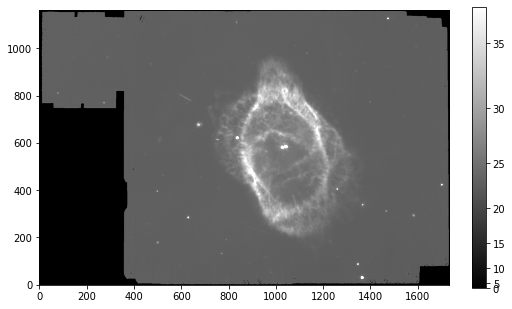

In [18]:
# Show the image.
norm = ImageNormalize(sci_data, 
                      interval=ZScaleInterval(),
                      stretch=SquaredStretch())
plt.figure(figsize=(8, 8))
plt.imshow(sci_data, cmap='gray', norm=norm, origin='lower')

# Colorbar
im_ratio = sci_data.shape[0]/sci_data.shape[1]
plt.colorbar(fraction=0.047*im_ratio)

# Short Pause!

Any questions or issues following along as we went through the basic of how to search and download data using the ERO observations of the Southern Ring Nebula?

Next: let's walk through how to download data for observations with LOTS of products and observations.

## Downloading Calibrated Data For Multi-Object Spectral Programs

Now to our original motivation: downloading data from a multi-object spectroscopic program.  For this tutorial, we are going to use NIRISS data from [Program 2736](https://www.stsci.edu/cgi-bin/get-proposal-info?id=2736&observatory=JWST), the ERO program targeting the galaxy cluster SMACS 0723.  Let's first do a search for this program to get the number of observations available.

In [9]:
# Get all JWST observations from Program 2736.  We only want the spectroscopic (wide-field slitless
# spectroscopy, or "WFSS") observations from NIRISS, so exclude the imaging mode observatons by specifying a
# product type in our observation query.
obs_table = Observations.query_criteria(obs_collection=["JWST"], proposal_id=[2736],
                                        instrument_name=["NIRISS"], dataproduct_type="spectrum")
n_obs = len(obs_table)
print("Number of observations: {0:d}".format(n_obs))

Number of observations: 1947


This one program has nearly two THOUSAND NIRISS observations at MAST.  Most of these are Stage 3 products in the form of extracted spectra.  If we try to submit this full list of observations, and ask for all the files that are associated with them, the service will need to return so many files that it will take a very long time, and could even time out!

In fact, for this program, there are 24,862 files across all the different instruments and stages of the pipeline products.  Worse still: some files are associated with more than one observation, so the query could return an even larger table of results because it returns all products under each observation, including duplicates shared by more than one observation (currently being addressed at the time of writing this notebook).  Even if we limit only to the highest-stage of calibrated products, there are more than 5,800 NIRISS extracted spectral FITS files one could retrieve.  We mention these numbers to caution you: <b>depending on the type of observation, there can be many products underneath a single observation at MAST</b>.  

So how *do* we download all the calibrated products for these observations?  If we follow the default process of calling `get_product_list()` on our observation table, and then running `download_products()` as we did for the MIRI observations in our basic example above, it won't work because `get_product_list()` always returns the full set of products for the requested observations (too many for the query to send back, as we discussed.)  But we *can* do it if we break up our requests into subsets of observations, we call `download_products()` directly on those subsets of observations, and we request only the calibrated data products to download.  Let's do that now.

In [16]:
# We will request products for the CAOM Observations in bunches to minimize
# the number of requests made, without trying to get back too many at once.
num_at_once = 5

# For the purposes of our tutorial, we don't *actually* want to download thousands of files, so instead of looping
# through the complete set of 1,900+ observations, let's trim our Astropy table to the first 20 rows.
# If you want to try to retrieve all the products on your own time, just comment out these two lines below.
obs_table = obs_table[-10:]
n_obs = len(obs_table)

# Loop through all the observations, and request the list of associated products in subsets.  We will pass the 
# `obsid` column in our Astropy table of observations to `download_products()` so it knows what records we want
# products for.  This by-passes the need to call `get_product_list()` first.

for batch, index in enumerate(range(0, n_obs, num_at_once)):
    
    # Make a list of the `obsid` identifiers from our Astropy table of observations to get products for.
    # We grab `num_at_once` rows at a time.
    if index+num_at_once <= n_obs:
        obsids = list(obs_table[index:index+num_at_once]['obsid'])
    else:
        obsids = list(obs_table[index:n_obs])
        
    # Progress indicator...
    print( f'Batch #{batch+1}' )
    print( f'For ``obsids``:' + '\n' + f'{obsids}' + '\n' )
    
    # Get list of products 
    products = Observations.get_product_list(obsids)
    
    # Filter the products to only get science products of calibration level 3 
    filtered_products = Observations.filter_products(products, productType=["SCIENCE"], calib_level=[3])
    
    # Download products for these records.
    manifest = Observations.download_products(filtered_products)

Batch #1
For ``obsids``:
['87605118', '87626880', '87626882', '87616107', '87605121']

INFO: Found cached file ./mastDownload/JWST/jw02736-o003_s00252_niriss_f200w-gr150c-gr150r/jw02736-o003_s00252_niriss_f200w-gr150c-gr150r_c1d.fits with expected size 57600. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02736-o003_s00252_niriss_f200w-gr150c-gr150r/jw02736-o003_s00252_niriss_f200w-gr150c-gr150r_cal.fits with expected size 3767040. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02736-o003_s00252_niriss_f200w-gr150c-gr150r/jw02736-o003_s00252_niriss_f200w-gr150c-gr150r_x1d.fits with expected size 613440. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02736-o003_s00323_niriss_f200w-gr150c-gr150r/jw02736-o003_s00323_niriss_f200w-gr150c-gr150r_c1d.fits with expected size 57600. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02736-o003_s00323_niriss_f200w-gr150c-gr150r/jw02736-o003_s00323_niriss_f200w-gr150c-gr150r_cal.

TODO: Add a short breakdown of `obsid` and how it compares to `Observation ID` in the Portal?  This might be too much information, or could be in the supplemental information?  It is worth explaining to people how it differs since we use it in the notebook *somewhere* I think.

(text to work on)
NOTE: the `obsid` parameter is an internal reference ID, defined by a unique integer, and is only used to look-up products in our cross-mission database tables by specific functions.  Since it is just a random, unique number, by itself it has no value to a user, and furthermore MAST reserves the right to change this value over time.

This is in stark contrast to the `Observation ID` column you see in the Portal browser (the `obs_id` column if using `astroquery.mast`), which *is* a more useful identifier to a given MAST observation, since it is a string that encodes information about the observation following rules defined by the mission.

In summary: `obsid` is a more-or-less random integer that contains no useful insignt other than to serve as a pointer to a particular observation at MAST.  It is used only by MAST functions behind-the-scenes or when calling `download_products()` without relying on the return value of `get_product_list()`.  `Observation ID` (in the Portal GUI) or `obs_id` (in `astroquery.mast`) is a unique string that follows a naming convention defined by the mission.